In [1]:
from SBTS import *
from schemes import *
from metrics import * 
from tools import *

Suppose that the process $X$ is the solution of the stochastic differential equation
$$dX_t = \theta(\mu - X_t)\, dt + \sigma\, dW_t,$$
where $\theta > 0$ denotes the speed of mean reversion, $\mu \in \mathbb{R}$ is the long-term mean, $\sigma > 0$ is the volatility, and $W = (W_t)_{t \ge 0}$ is a standard Brownian motion. We further assume that $X_0 = 1$.

Applying Itô’s formula with $f(t,x) = e^{\theta t} x$, we obtain
$$X_{t+\Delta}
= e^{-\theta \Delta} X_t
+ \mu \bigl(1 - e^{-\theta \Delta}\bigr)
+ \sigma e^{-\theta (t+\Delta)}
\int_t^{t+\Delta} e^{\theta s}\, dW_s.$$

As a consequence,
$$X_{t+\Delta} \mid X_t \sim \mathcal{N}(\mu_t, \sigma_t^2),
\quad
\mu_t = e^{-\theta \Delta} X_t + \mu \bigl(1 - e^{-\theta \Delta}\bigr),
\quad
\sigma_t^2 = \frac{\sigma^2}{2\theta}\left(1 - e^{-2\theta \Delta}\right).$$
The log-likelihood associated with a trajectory $(X_{t_i}^{(m)})_{i=0,\ldots,N}$ is then given by
$$\ell(\theta, \mu, \sigma; X^{(m)})
= -\frac{1}{2} \sum_{i=0}^{N-1}
\left\{
\ln \bigl(2\pi (\sigma_{t_i}^{(m)})^2\bigr)
+
\frac{\bigl(X_{t_{i+1}}^{(m)} - \mu_{t_i}^{(m)}\bigr)^2}
{(\sigma_{t_i}^{(m)})^2}
\right\},$$
for $m = 1, \ldots, M.$ Here, $\mu_{t_i}^{(m)}$ and $\sigma_{t_i}^{(m)}$ denote the quantities defined above associated with the $m$-th sample path.

In order to provide the generator with stationary trajectories, we apply the following normalization: $$(\widetilde{X}_{t_0}^{(m)}, \widetilde X_{t_1}^{(m)}, \ldots, \widetilde{X}_{t_i}^{(m)}, \ldots, \widetilde{X}_{t_N}^{(m)}) = \left(0, \ln\left(\frac{X_{t_1}^{(m)}}{X_{t_0}^{(m)}}\right), \ldots, \ln\left(\frac{X_{t_i}^{(m)}}{X_{t_{i-1}}^{(m)}}\right),\ldots, \ln\left(\frac{X_{t_N}^{(m)}}{X_{t_{N-1}}^{(m)}}\right) \right).$$

We consider $M = 1000$ reference trajectories, with $N = 252$ time steps over a time horizon $T = 1$, corresponding to a time step $\Delta = 1/252$.
During the generation of synthetic trajectories, the Euler scheme is employed with an internal discretization of $N_\pi = 200$, and the selected hyperparameters are $(h, r) = (0.05, 10)$.

Although the underlying trajectories are first-order Markovian, we empirically observe that
$\mathrm{MSE}(\cdot, r = 10) < \mathrm{MSE}(\cdot, r = 1).$
This behavior can be explained by a bias–variance trade-off: increasing $r$ introduces a small bias (as conditioning is performed on more information than required in a purely Markovian model), but significantly reduces the variance of the estimator.
In practice, using a temporal window $r > 1$ therefore acts as a form of regularization, by exploiting the local temporal structure of the signal.

### I. Fixed parameters 

#### I.1. Generation of synthetic trajectories 

In [7]:
theta, mu, sigma = 1.5, 1.0, 0.3
N = 252
T = N/252
S0 = 1 
M = 1000
delta = T/N 
Z = np.random.normal(0.0, 1.0, size = (M, N))
X = simulate_OU_fixed_parameters(M, N, Z, S0, T, theta, mu, sigma) 
log_returns = np.zeros((M,N+1))
log_returns[:, 1:] = np.diff(np.log(X), axis = 1)
std = log_returns[:, 1:].std(ddof=1)
log_returns = log_returns  * np.sqrt(delta) / std

In [9]:
log_returns.std() - np.sqrt(delta)
std, np.sqrt(delta)

(0.019509292285821007, 0.06299407883487121)

In [11]:
h = 0.05 
N_pi = 100
r = 10 
vals = simulate_SBTS_trajectories(log_returns, 1000, h, delta, N_pi, x0=0.0, markov_proj=True, r=r)

100%|███████████████████████████████████████| 1000/1000 [05:01<00:00,  3.32it/s]


In [18]:
vals *= std / np.sqrt(delta)
vals_ = np.exp(vals.cumsum(axis = 1))

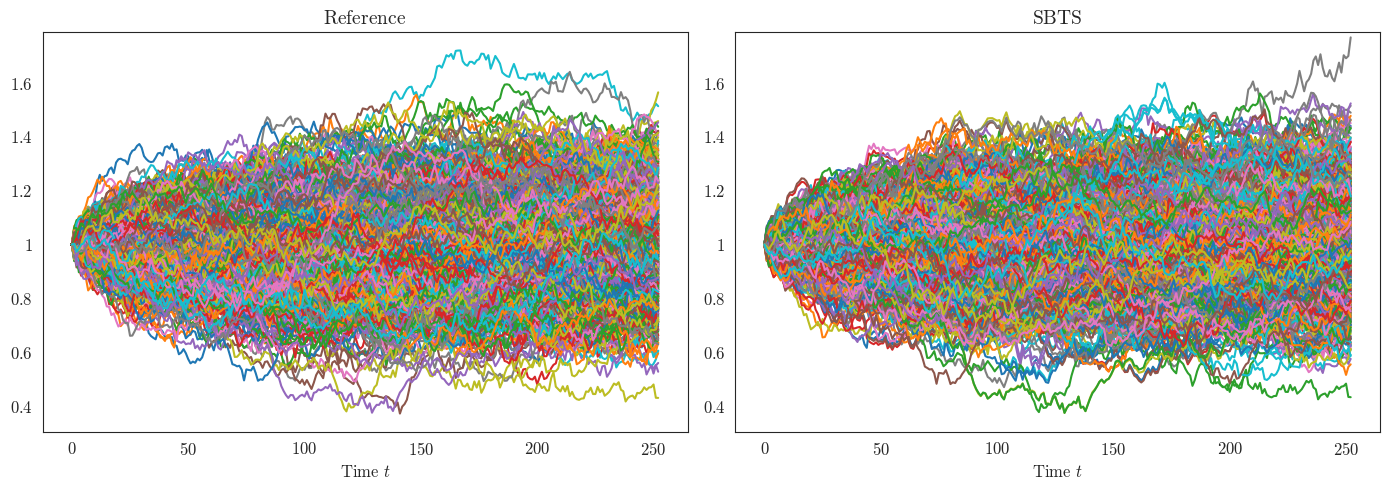

In [22]:
plot_traj_12(X, vals_, samelim=True) 

#### I.2. Parameters estimation

In [26]:
bounds = np.array([
    (0.5, 250),    # theta 
    (0.0, 10),     # mu 
    (0.001, 0.5),  # sigma
    ])

In [28]:
params_opt, _ = predict_params_OU(X, delta, bounds)
params_opt_SBTS, _ = predict_params_OU(vals_, delta, bounds)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 268.65it/s]


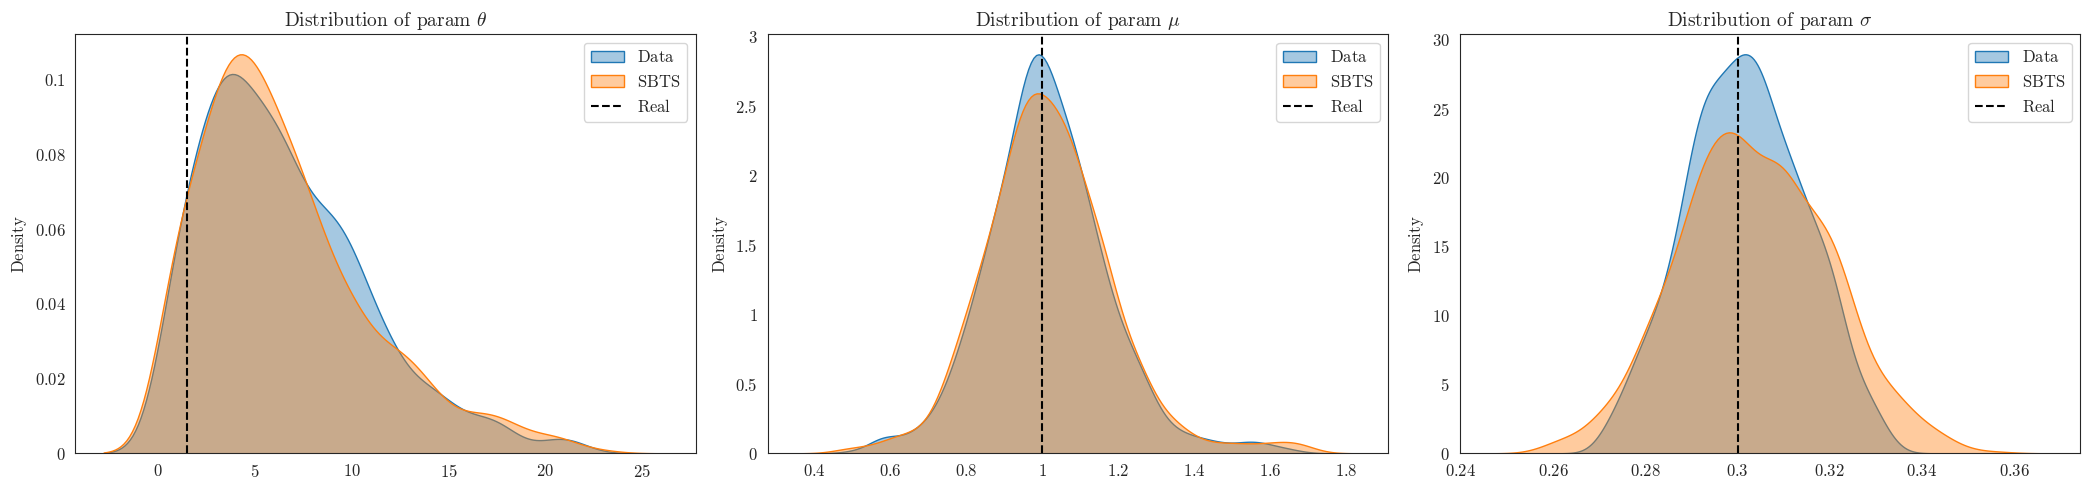

In [30]:
plot_distrib_OU(theta, mu, sigma, params_opt, params_opt_SBTS)

#### I.3. Discriminative score

In [30]:
discriminative_scores_det, predictive_scores_det = scores(X, vals_, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = False)

100%|██████████████████████████████████████████| 10/10 [29:58<00:00, 179.88s/it]

Discriminative score : 0.027 +- 0.012
Predictive score : 0.0 +- 0.0


### II. Random parameters 

#### II.1. Generation of synthetic trajectories 

In [119]:
N = 252 
T = N/252 
S0 = 1

M = 1000
Z = np.random.normal(0.0, 1.0, size = (M, N))
delta = T/N 

theta_random = np.random.uniform(0.5, 2.5, size = M)
mu_random = np.random.uniform(0.5, 1.5, size = M)
sigma_random = np.random.uniform(0.1, 0.5, size = M)
X_random = simulate_OU_random_parameters(M, N, Z, S0, T, theta_random, mu_random, sigma_random)
mask = np.all(X_random > 0.0, axis=1)  
X_random = X_random[mask]

log_returns = np.zeros((X_random.shape[0],N+1))
log_returns[:, 1:] = np.diff(np.log(X_random), axis = 1)
std = log_returns[:, 1:].std(ddof=1)
log_returns = log_returns * np.sqrt(delta) / std

In [139]:
h = 0.05
r = 10
N_pi = 100
vals_random = simulate_SBTS_trajectories(log_returns, 1000, h, delta, N_pi, x0=0.0, markov_proj=True, r=r)

100%|███████████████████████████████████████| 1000/1000 [05:14<00:00,  3.18it/s]


In [147]:
vals_random *= std / np.sqrt(delta)
vals_ = np.exp(vals_random.cumsum(axis = 1))

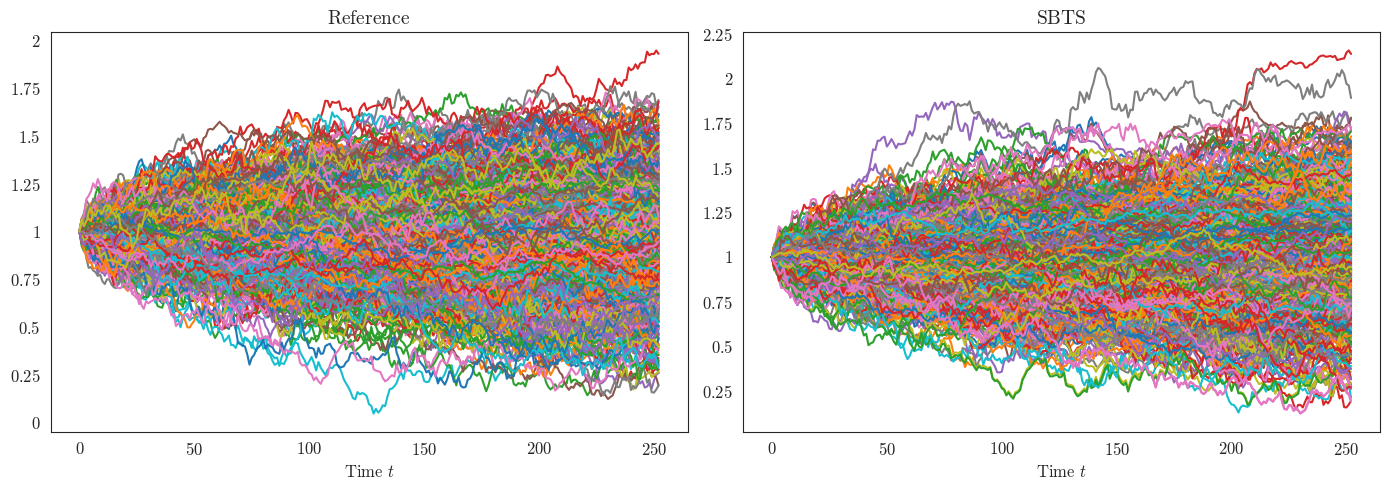

In [180]:
plot_traj_12(X_random[200:], vals_[200:-1])

#### II.2. Parameters estimation

In [152]:
bounds_random = np.array([
    (0.2, 250),  # theta 
    (0.0, 10),   # mu 
    (0.001, 1),  # sigma
    ])

params_opt_random, _ = predict_params_OU(X_random, delta, bounds_random)
params_opt_SBTS_random, _ = predict_params_OU(vals_, delta, bounds_random)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 241.59it/s]


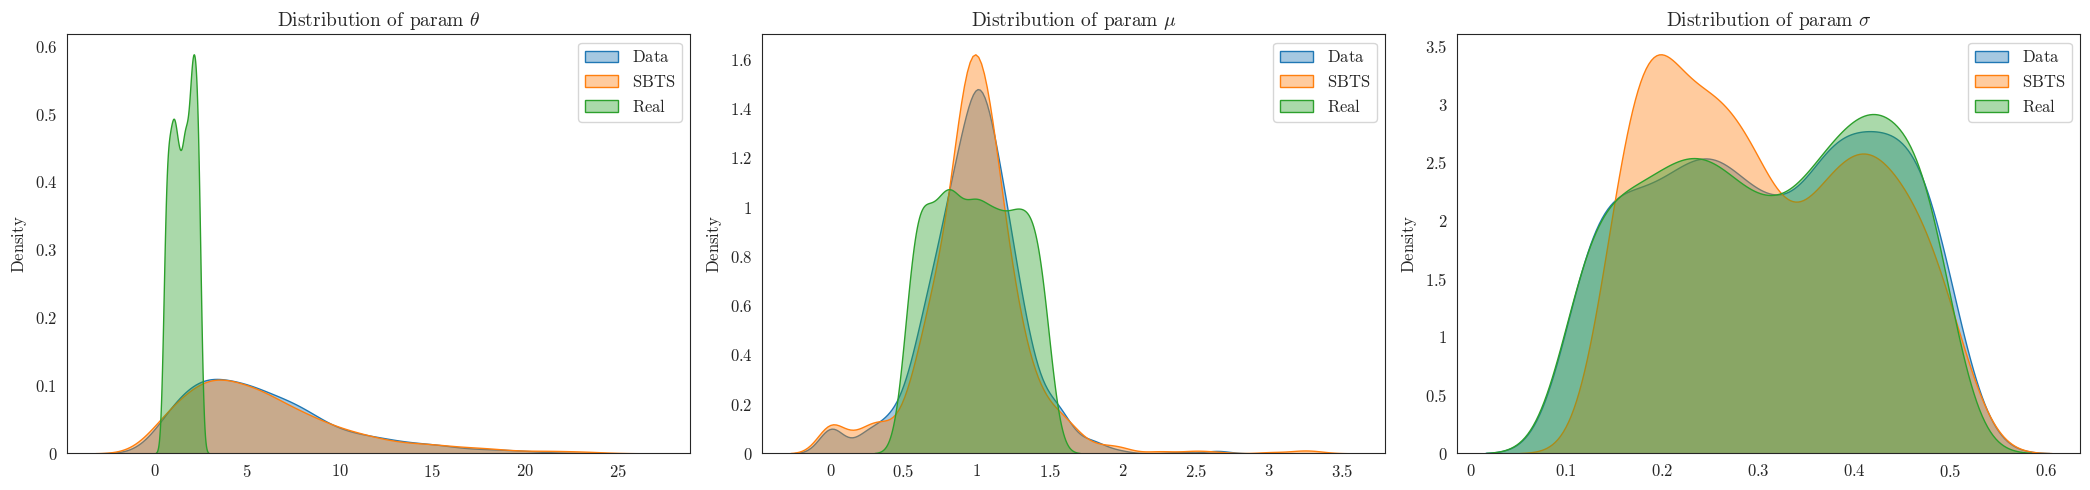

In [154]:
plot_distrib_OU_random(theta_random, mu_random, sigma_random, params_opt_random, params_opt_SBTS_random)

#### II.3. Discriminative score

In [62]:
discriminative_scores_rdm, predictive_scores_rdm = scores(X_random, vals_, col_pred = None, 
                                                  iterations = 2000, n_temp = 10, min_max = True, both = False)

100%|██████████████████████████████████████████| 10/10 [31:28<00:00, 188.83s/it]

Discriminative score : 0.026 +- 0.018
Predictive score : 0.0 +- 0.0
